In [3]:
import os                   # to interact with the operating system
import glob

import numpy as np
import pandas as pd
import xarray as xr

import pop_tools

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.feature as cfeature

import cmocean.cm as cmo
import matplotlib.ticker as ticker


ccrs = cartopy.crs

nature_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',linewidth=0.5, edgecolor='black', facecolor='darkgray')

In [4]:
psl_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/PSLcomposite.nc'
ds_psl = xr.open_dataset(psl_file)

# Plot composite pressure anomaly

In [2]:
psl_file = os.path.expanduser('~/phase1_CONDA/')+'/results/composites/psl_anomaly.nc'
ds_psl = xr.open_dataset(psl_file)

plotting_data = ds_psl.PSL

In [3]:
vmin = -abs(ds_psl.PSL.max())
vmax = -vmin

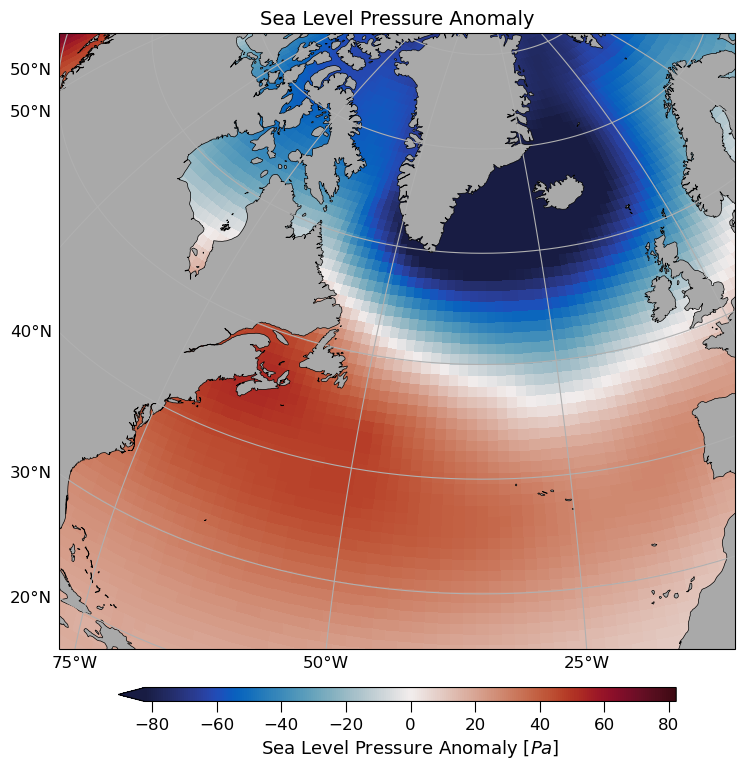

In [6]:
cbar_kwargs = {'orientation':'horizontal', 'shrink':0.8, 'aspect':40, 
               'label':r'Sea Level Pressure Anomaly [$Pa$]', 'pad': 0.05}

plt.figure(figsize=(9,10));
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=40, central_longitude=-35))
ax.set_extent([-80,-10, 25, 80], crs=ccrs.PlateCarree())

pc = plotting_data.plot.pcolormesh(ax=ax, 
                                    transform=ccrs.PlateCarree(),
                                    x='lon', 
                                    y='lat',
                                    cbar_kwargs=cbar_kwargs,
                                    cmap=cmo.balance,
                                    vmin = vmin, vmax = vmax, 
                                    )
pc.colorbar.ax.xaxis.label.set_size(13)
pc.colorbar.ax.tick_params(axis='x', labelsize=12, size=8)
ax.tick_params(axis='both', which='both', labelsize=12, size=6)


gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

ax.add_feature(nature_coast);
plt.title('Sea Level Pressure Anomaly', fontsize=14)
plt.show()

# Compute first EOF of composite time series

- which area am interested in? --> North Atlantic sector (20°-70°N, 90°W-40°E) by Hurrell et al. 2003
- stupid data with now again a different grid and the stupid 0 line exactly in my area. How do i deal with that?

## select area of interest and reduce dataset 

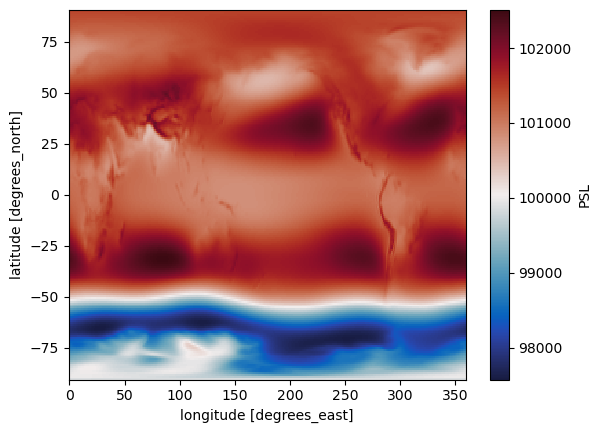

In [74]:
ds_psl.PSL.isel(time=0).plot(cmap=cmo.balance)

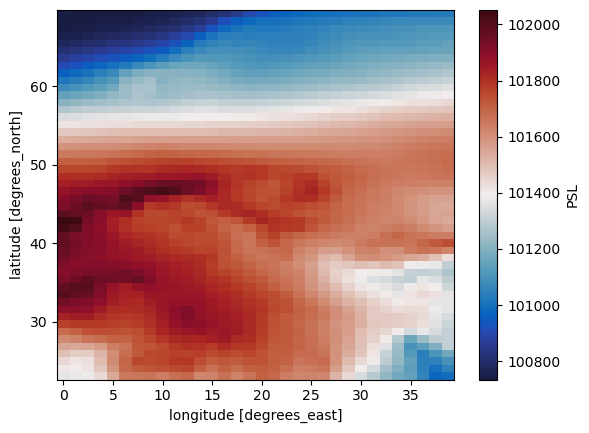

In [80]:
east_ds = ds_psl.isel(lat=slice(120,170), lon=slice(0, 32))
east_ds.PSL.isel(time=0).plot(cmap=cmo.balance)

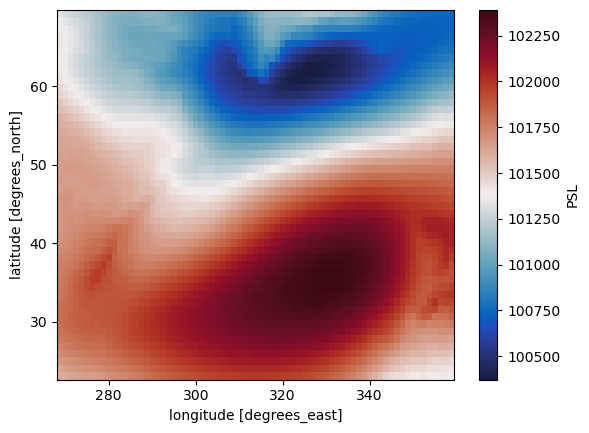

In [81]:
west_ds = ds_psl.isel(lat=slice(120,170), lon=slice(215, 288))
west_ds.PSL.isel(time=0).plot(cmap=cmo.balance)

In [68]:
print('40deg East', 360+40)
print('90deg West', 360-90)
print('')
print('east range: 0-32 - ', 288+32-80)
print('west range: 215-288', 215-80)

40deg East 400
90deg West 270

east range: 0-32 -  240
west range: 215-288 135


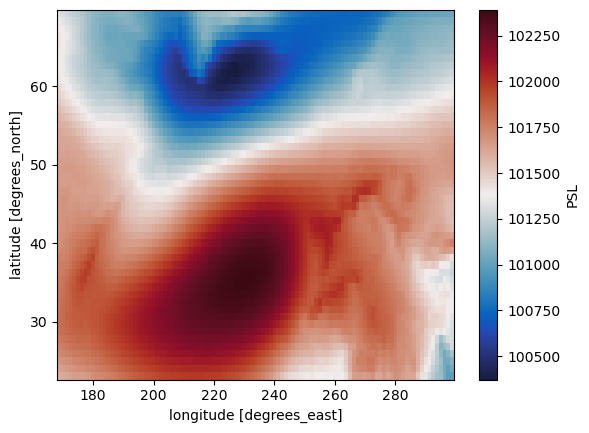

In [82]:
reduced_ds = ds_psl.roll(lon=-80).isel(lat=slice(120,170), lon=slice(135, 240))
reduced_ds.PSL.isel(time=0).plot(cmap=cmo.balance)

## figure out the weights

`gw`... latitude weights

In [26]:
parameter_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/psl/psl_1231.001.nc'
ps_ds = xr.open_dataset(parameter_file)

reduced_ds = ps_ds.roll(lon=-80).isel(lat=slice(120,170), lon=slice(135, 240))

In [27]:
data = reduced_ds.PSL.values
weights = reduced_ds.gw.values
print(data.shape, weights.shape)

(3012, 50, 105) (50,)


In [28]:
weights = weights[np.newaxis, :,  np.newaxis]
print(weights.shape)

(1, 50, 1)


## Test EOF approach

EOF Steps:

- spatial weighting with given latitude weights
- replace nans with mean of time step
- center data (data-mean(data))
- compute covariance matrix
- compute eigenvalues and eigenvectors

In [29]:
data, weights = data, weights

# spatial weighting
weighted_data = data * weights
# reshape data into a 2D array (time, space)
shape = weighted_data.shape
data_2d = weighted_data.reshape(shape[0], -1)

# mean per time step
mean_per_time_step = np.nanmean(data_2d, axis=1)
# replace nans with mean of time step
nan_indices = np.isnan(data_2d)
data_2d[nan_indices] = np.take(mean_per_time_step, np.where(nan_indices)[0])

# mean per location
mean = np.mean(data_2d, axis=0)
# center data
centered_data = data_2d - mean

# covariance matrix
cov_matrix = np.cov(centered_data, rowvar=False)
# eigen decomposition
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
# sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

In [30]:
eigenvectors.shape

(5250, 5250)

In [31]:
eigenvalues.shape

(5250,)

The dot product between the centered data and the first principal component eigenvector effectively projects the centered data onto the direction defined by the first principal component. This projection yields the 1st principal component time series, which represents the variation along this dominant direction in the data space.

In [32]:
first_principal_component = np.dot(centered_data, eigenvectors[:, 0])

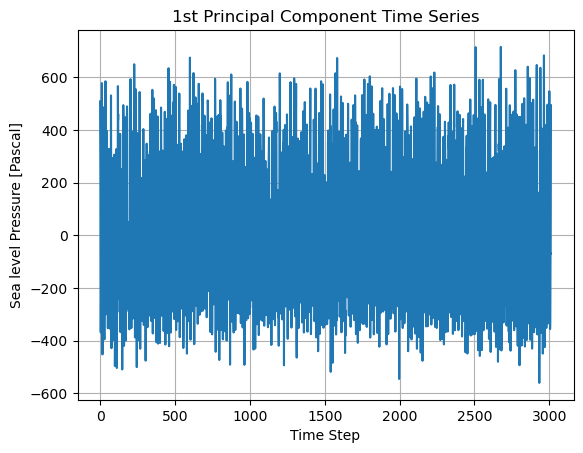

In [33]:
# Generate x-axis values (assuming each time step corresponds to an index)
time_steps = range(len(first_principal_component))

# Plot the 1st principal component time series
plt.plot(time_steps, first_principal_component)
plt.title('1st Principal Component Time Series')
plt.xlabel('Time Step')
plt.ylabel('Sea level Pressure [Pascal]')
plt.grid(True)
plt.show()

### Plot spatial pattern

In [36]:
# Reshape the first eigenvector back to spatial grid
eof1_map = eigenvectors[:, 0].reshape(shape[1:])

The spatial pattern of the first EOF shows a negative phase.


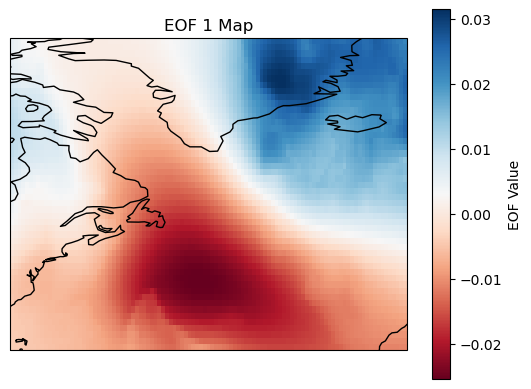

In [35]:
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': projection})
img = ax.imshow(eof1_map, cmap='RdBu', extent=[-80,-10, 25, 80], origin='upper')
ax.coastlines()
ax.set_title('EOF 1 Map')

# Add colorbar
cbar = plt.colorbar(img, ax=ax, orientation='vertical')
cbar.set_label('EOF Value')

plt.show()

### Determine the sign of the time series

If the pressure anomaly pattern resembles the typical positive phase of the NAO (i.e., higher pressure over the Azores and lower pressure over Iceland), then positive values of the associated time series correspond to the positive phase of the NAO, and negative values correspond to the negative phase. Conversely, if the pattern is reversed, the interpretation of the sign is also reversed.

In [ ]:
# Check if the first EOF spatial pattern shows a negative phase
rows, cols = eof1_map.shape
upper_right_quadrant = eof1_map[:rows//2, cols//2:]
if np.mean(upper_right_quadrant) < 0:
    print("The spatial pattern of the first EOF shows a negative phase.")

## Compute NAO

In [14]:
psl_files = sorted( glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/psl_composite_*.nc'))

for file in psl_files:
    print(file[-11:-3])

1231.001
1231.003
1231.004
1231.020
1251.010
1281.010
1281.012
1281.015
1281.017
1281.020
1301.001
1301.015
1301.019


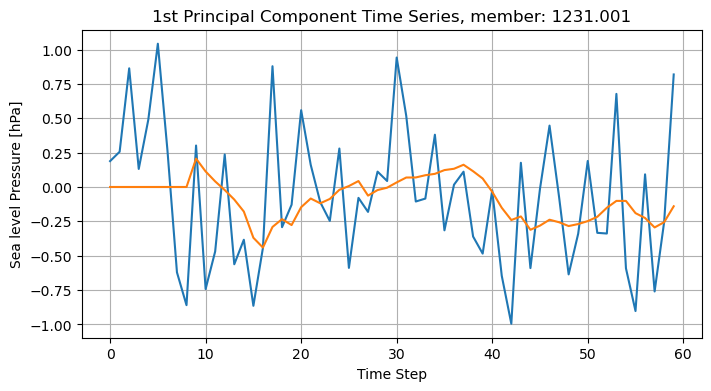

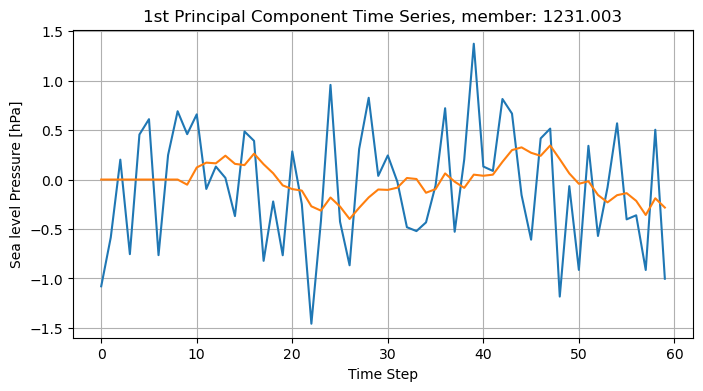

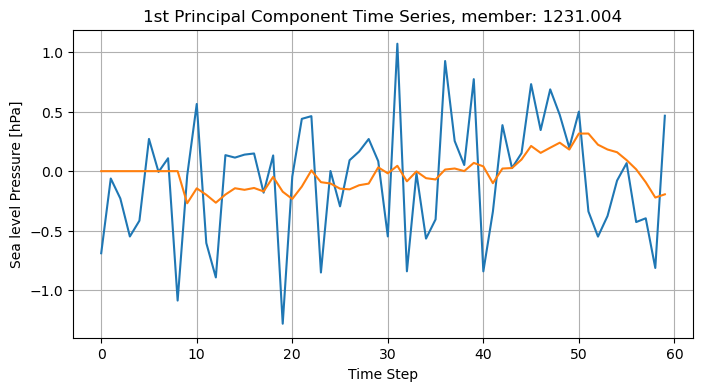

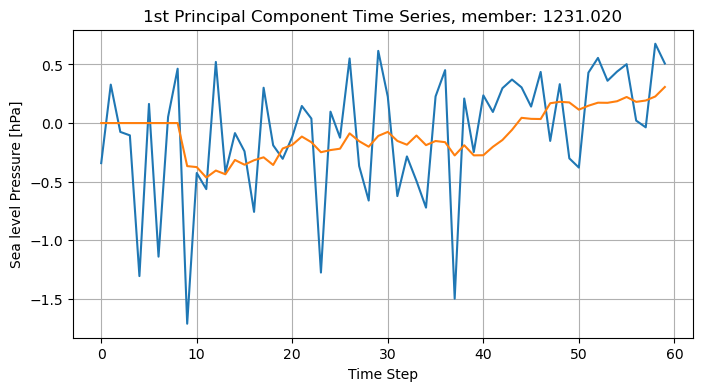

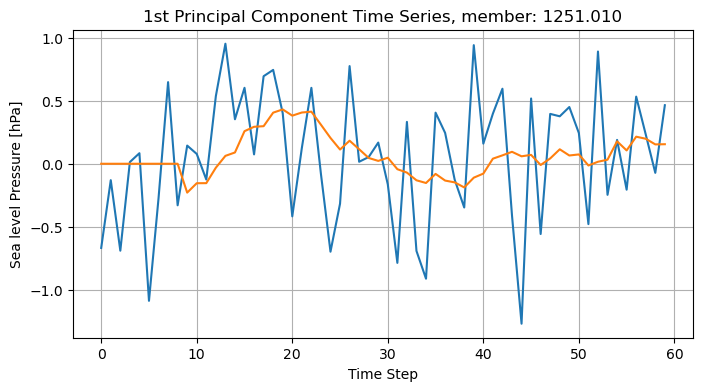

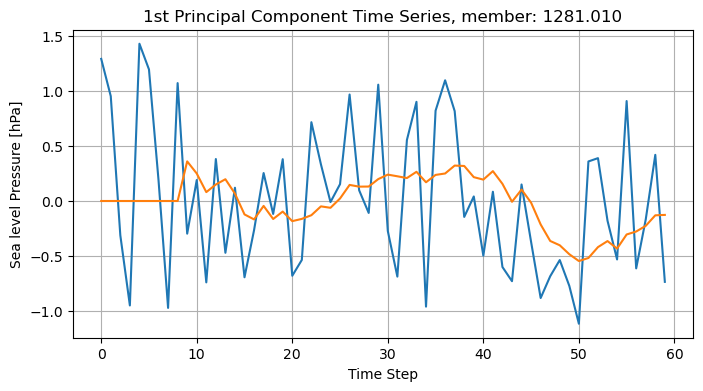

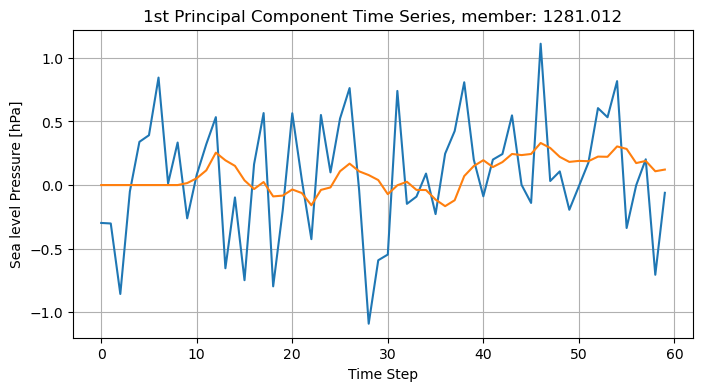

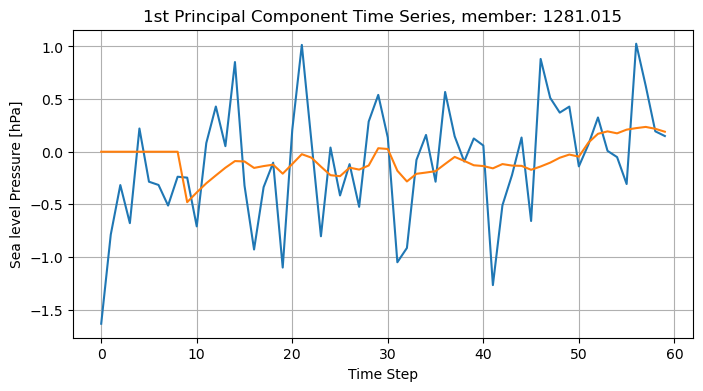

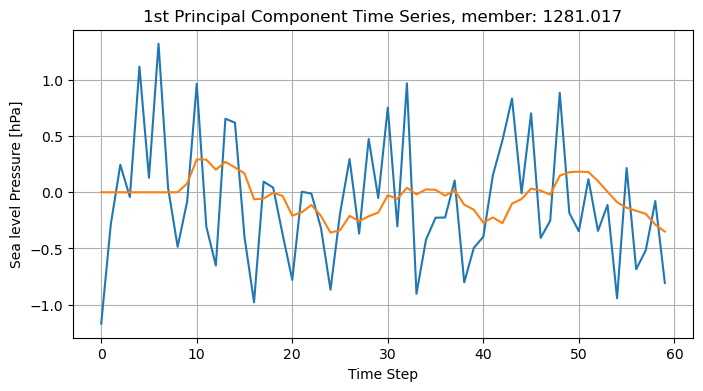

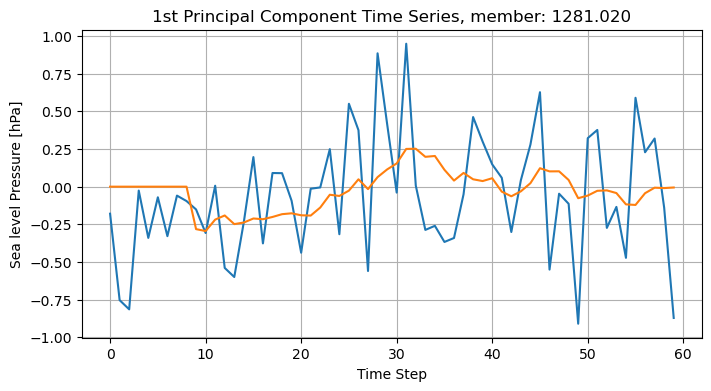

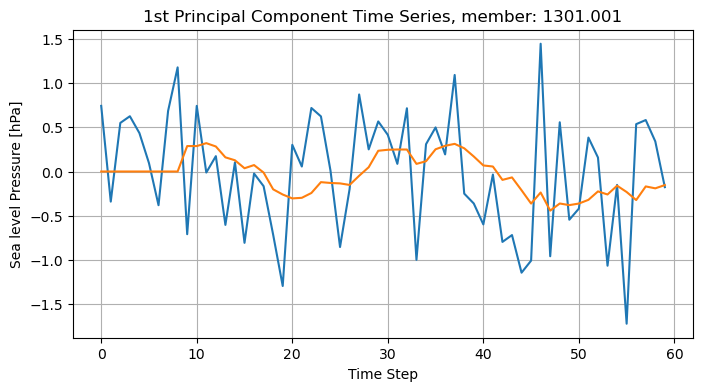

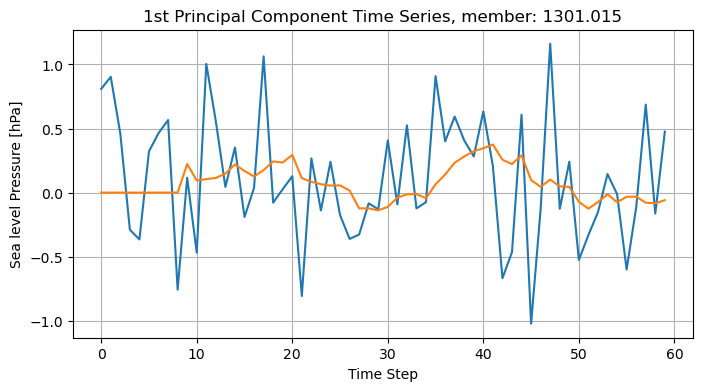

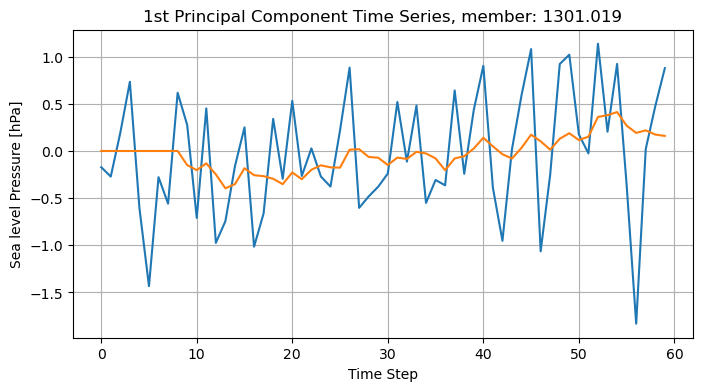

In [21]:
psl_files = sorted( glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/psl_composite_*.nc'))

for file in psl_files:
    psl_ds = xr.open_dataset(file)

    reduced_ds = psl_ds.roll(lon=-80).isel(lat=slice(120,170), lon=slice(135, 240))

    data = reduced_ds.PSL.values
    weights = reduced_ds.gw.isel(time=0).values
    weights = weights[np.newaxis, :,  np.newaxis]

    # spatial weighting
    weighted_data = data * weights
    # reshape data into a 2D array (time, space)
    shape = weighted_data.shape
    data_2d = weighted_data.reshape(shape[0], -1)

    # mean per time step
    mean_per_time_step = np.nanmean(data_2d, axis=1)
    # replace nans with mean of time step
    nan_indices = np.isnan(data_2d)
    data_2d[nan_indices] = np.take(mean_per_time_step, np.where(nan_indices)[0])

    # mean per location
    mean = np.mean(data_2d, axis=0)
    # center data
    centered_data = data_2d - mean

    # covariance matrix
    cov_matrix = np.cov(centered_data, rowvar=False)
    # eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    # sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    first_principal_component = np.dot(centered_data, eigenvectors[:, 0])
    first_principal_component = first_principal_component[:-1]

    # Generate x-axis values (assuming each time step corresponds to an index)
    time_steps = range(len(first_principal_component))
    
    # Calculate the moving average
    window_size = 10
    moving_avg = np.convolve(first_principal_component, np.ones(window_size)/window_size, mode='valid')
    moving_avg = np.concatenate((np.zeros(9), moving_avg))

    # Plot the 1st principal component time series
    plt.figure(figsize=(8, 4))
    plt.plot(time_steps, first_principal_component * 1e-2, label='Original Time Series')
    plt.plot(time_steps, moving_avg * 1e-2, label='10-Year Moving Average NAO Index')
    plt.title('1st Principal Component Time Series, member: '+str(file[-11:-3]))
    plt.xlabel('Time Step')
    plt.ylabel('Sea level Pressure [hPa]')
    plt.grid(True)
    plt.show()
    #plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'NAO_index_'+str(file[-11:-3])+'.png', bbox_inches='tight', dpi=300)   

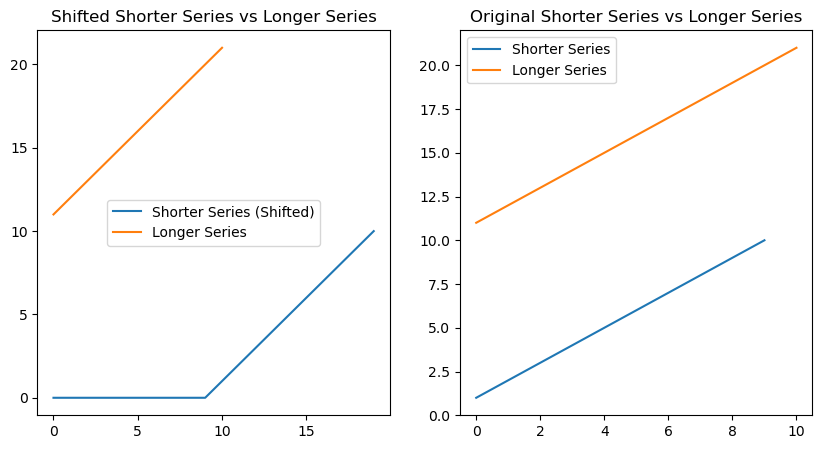

In [18]:
# Example time series data
shorter_series = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])  # Shorter by 10 steps
longer_series = np.array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])  # Longer

# Shift the shorter series forward by 10 steps
shifted_shorter_series = np.concatenate((np.zeros(10), shorter_series))

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(shifted_shorter_series, label='Shorter Series (Shifted)')
plt.plot(longer_series, label='Longer Series')
plt.title('Shifted Shorter Series vs Longer Series')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(shorter_series, label='Shorter Series')
plt.plot(longer_series, label='Longer Series')
plt.title('Original Shorter Series vs Longer Series')
plt.legend()

plt.show()

In [119]:
def EOF(data, weights):
    
    weights = weights[np.newaxis, :,  np.newaxis]

    # spatial weighting
    weighted_data = data * weights
    # reshape data into a 2D array (time, space)
    shape = weighted_data.shape
    data_2d = weighted_data.reshape(shape[0], -1)
    
    # mean per time step
    mean_per_time_step = np.nanmean(data_2d, axis=1)
    # replace nans with mean of time step
    nan_indices = np.isnan(data_2d)
    data_2d[nan_indices] = np.take(mean_per_time_step, np.where(nan_indices)[0])
    
    # mean per location
    mean = np.mean(data_2d, axis=0)
    # center data
    centered_data = data_2d - mean
    
    # covariance matrix
    cov_matrix = np.cov(centered_data, rowvar=False)
    # eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    # sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # EOF 1 time series 
    principal_components = eigenvectors[:, 0:1]
    # Project the data onto the principal components
    projected_data = centered_data.dot(principal_components)
    # Reconstruct the data from the principal component:
    reconstructed_data = (projected_data.dot(principal_components.T) + mean)
    reconstructed_data[nan_indices] = np.nan
    # Reshape the reconstructed data to the original shape
    original_shape_data = reconstructed_data.reshape(shape)
    original_shape_data = original_shape_data /weights
    
    eof1 = np.nanmax(original_shape_data, axis=(1,2))

    return principal_components, original_shape_data, eof1

In [123]:
principal_components, original_shape_data, eof1 = EOF(data, weights)

In [124]:
print(principal_components.shape)
print(original_shape_data.shape)

(5250, 1)
(60, 50, 105)


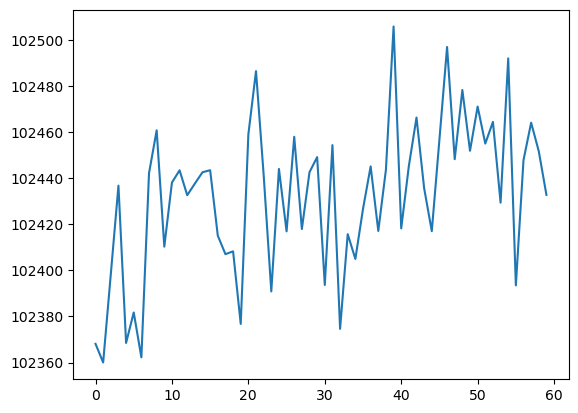

In [125]:
plt.plot(eof1)

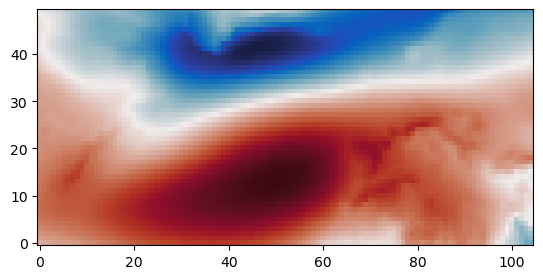

In [126]:
plt.imshow(original_shape_data[0,:,:], origin='lower', cmap=cmo.balance)

In [129]:
mean_along_axis_0 = np.mean(original_shape_data, axis=0)

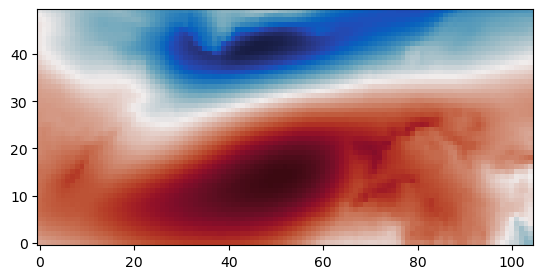

In [130]:
plt.imshow(mean_along_axis_0, origin='lower', cmap=cmo.balance)

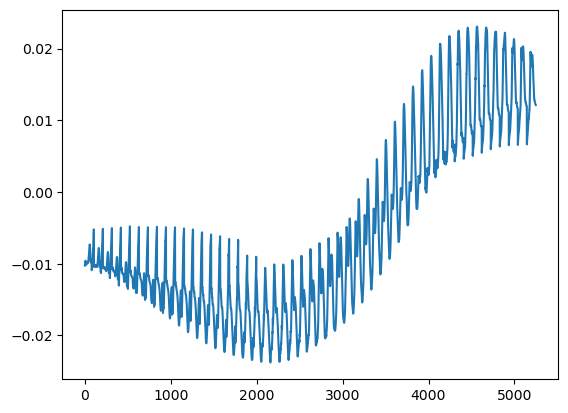

In [131]:
plt.plot(principal_components)